In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
RANDOM_STATE = 1
df = pd.read_csv("../data/clean_train.csv")
df.head(3)
df['solo_man'] = ((df.age > 13) * (df.sex == 'male')).astype(int)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,cabin_deck,solo
0,0,lower,"braund,_mr._owen_harris",male,22.0,1,0,a/5_21171,7.2500,unknown,s,u,0
1,1,upper,"cumings,_mrs._john_bradley_(florence_briggs_th...",female,38.0,1,0,pc_17599,71.2833,c85,c,c,0
2,1,lower,"heikkinen,_miss._laina",female,26.0,0,0,ston/o2._3101282,7.9250,unknown,s,u,1


In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

y_train = df_train['survived'].values
y_val = df_val['survived'].values

del df_train['survived']
del df_val['survived']

In [ ]:
numerical_features = ['age', 'sibsp', 'parch', 'fare']
categorical_features = ['pclass', 'sex', 'embarked', 'cabin_deck', 'solo']

In [ ]:
lr_params = {
    'C': 1.0,
    'max_iter': 1000
}

In [ ]:
def train(df_train, y_train, features, **lr_params):
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(**lr_params)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, features, model):
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


In [ ]:
dv, model = train(df_train, y_train, categorical_features + numerical_features, **lr_params)
y_pred = predict(df_val, dv, categorical_features + numerical_features, model)
y_pred_train = predict(df_train, dv, categorical_features + numerical_features, model)


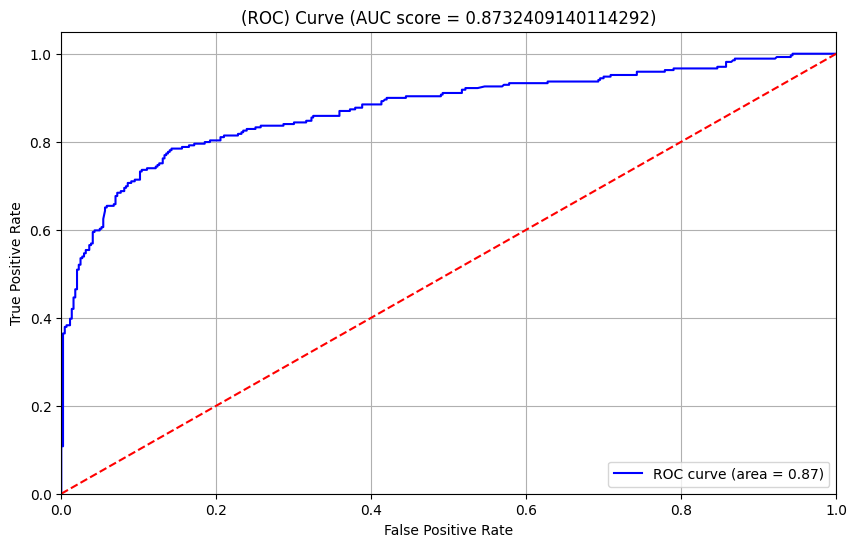

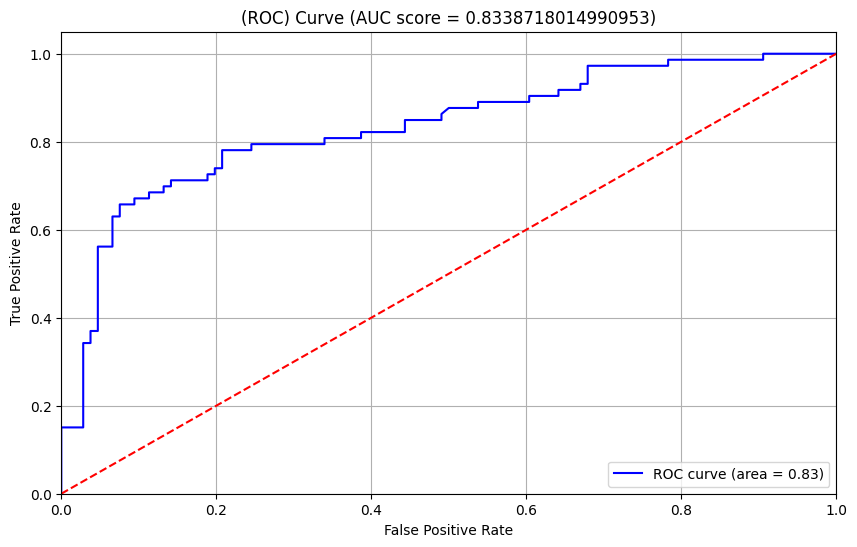

In [ ]:
# plot roc curve
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true=y_true, y_score=y_score)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'(ROC) Curve (AUC score = {auc_score})')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    
plot_roc_curve(y_true=y_train, y_score=y_pred_train)
plot_roc_curve(y_true=y_val, y_score=y_pred)

In [ ]:
coeff_scores = list(zip(abs(model.coef_[0].round(3)), dv.get_feature_names_out()))
coeff_scores.sort(reverse=True)
coeff_scores

[(np.float64(1.279), 'sex=male'),
 (np.float64(1.278), 'sex=female'),
 (np.float64(1.123), 'cabin_deck=e'),
 (np.float64(0.931), 'pclass=lower'),
 (np.float64(0.893), 'cabin_deck=u'),
 (np.float64(0.688), 'solo'),
 (np.float64(0.572), 'pclass=upper'),
 (np.float64(0.535), 'sibsp'),
 (np.float64(0.405), 'embarked=s'),
 (np.float64(0.405), 'cabin_deck=c'),
 (np.float64(0.358), 'pclass=middle'),
 (np.float64(0.336), 'cabin_deck=d'),
 (np.float64(0.327), 'cabin_deck=f'),
 (np.float64(0.266), 'cabin_deck=t'),
 (np.float64(0.263), 'cabin_deck=b'),
 (np.float64(0.259), 'cabin_deck=g'),
 (np.float64(0.226), 'cabin_deck=a'),
 (np.float64(0.181), 'embarked=q'),
 (np.float64(0.176), 'embarked=unknown'),
 (np.float64(0.129), 'parch'),
 (np.float64(0.047), 'embarked=c'),
 (np.float64(0.04), 'age'),
 (np.float64(0.001), 'fare')]

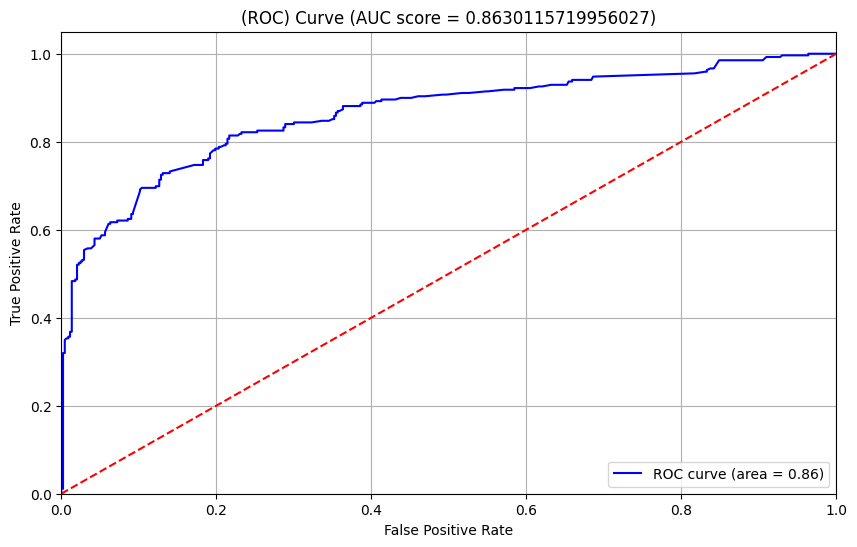

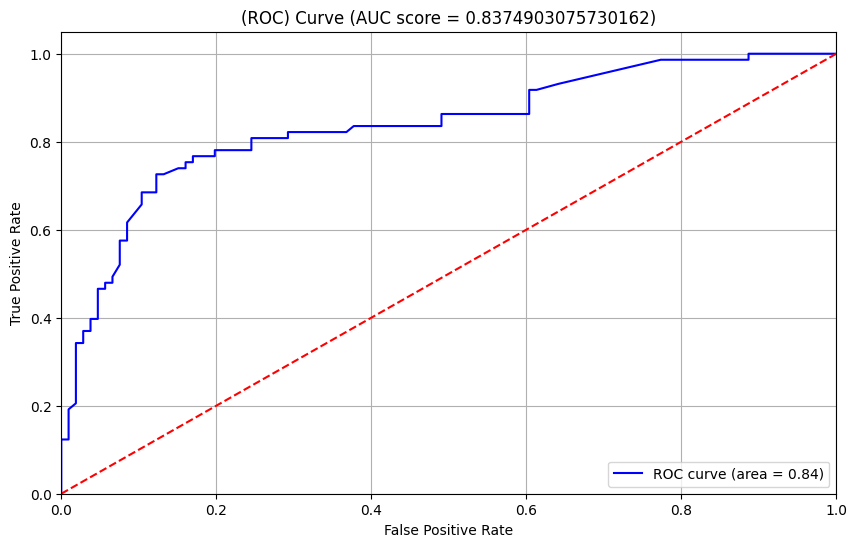

In [ ]:
features = ['age', 'sex', 'pclass', 'sibsp', 'solo', 'parch']
dv, model = train(df_train, y_train, features, **lr_params)
y_pred = predict(df_val, dv, features, model)
y_pred_train = predict(df_train, dv, features, model)

plot_roc_curve(y_true=y_train, y_score=y_pred_train)
plot_roc_curve(y_true=y_val, y_score=y_pred)

# Regularization

In [ ]:
features = ['age', 'sex', 'pclass', 'sibsp', 'solo', 'parch']
for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    lr_params['C'] = C
    dv, model = train(df_train, y_train, features, **lr_params)
    y_pred = predict(df_val, dv, features, model)
    y_pred_train = predict(df_train, dv, features, model)
    score = roc_auc_score(y_val, y_pred)
    print((C, score))    

(0.001, 0.7466399586456449)
(0.01, 0.8187516154044973)
(0.1, 0.8367149134143189)
(1, 0.8374903075730162)
(10, 0.8371026104936675)
(100, 0.8371026104936675)
(1000, 0.8371026104936675)


In [ ]:
features = ['age', 'sex', 'pclass', 'sibsp', 'solo', 'parch']
for C in np.linspace(0.1, 2, 20):
    lr_params['C'] = C
    dv, model = train(df_train, y_train, features, **lr_params)
    y_pred = predict(df_val, dv, features, model)
    y_pred_train = predict(df_train, dv, features, model)
    score = roc_auc_score(y_val, y_pred)
    print((C, score))    

(np.float64(0.1), 0.8367149134143189)
(np.float64(0.2), 0.8380072370121477)
(np.float64(0.3), 0.8376195399327991)
(np.float64(0.4), 0.8369733781338846)
(np.float64(0.5), 0.8369733781338846)
(np.float64(0.6), 0.8372318428534504)
(np.float64(0.7), 0.8374903075730161)
(np.float64(0.7999999999999999), 0.837748772292582)
(np.float64(0.8999999999999999), 0.837748772292582)
(np.float64(0.9999999999999999), 0.8374903075730162)
(np.float64(1.0999999999999999), 0.8372318428534504)
(np.float64(1.2), 0.8372318428534504)
(np.float64(1.3), 0.8371026104936675)
(np.float64(1.4), 0.8371026104936675)
(np.float64(1.5), 0.8373610752132333)
(np.float64(1.5999999999999999), 0.8369733781338846)
(np.float64(1.7), 0.8373610752132334)
(np.float64(1.8), 0.8373610752132334)
(np.float64(1.9), 0.8374903075730162)
(np.float64(2.0), 0.8372318428534505)


In [ ]:
lr_params['C'] = 0.8

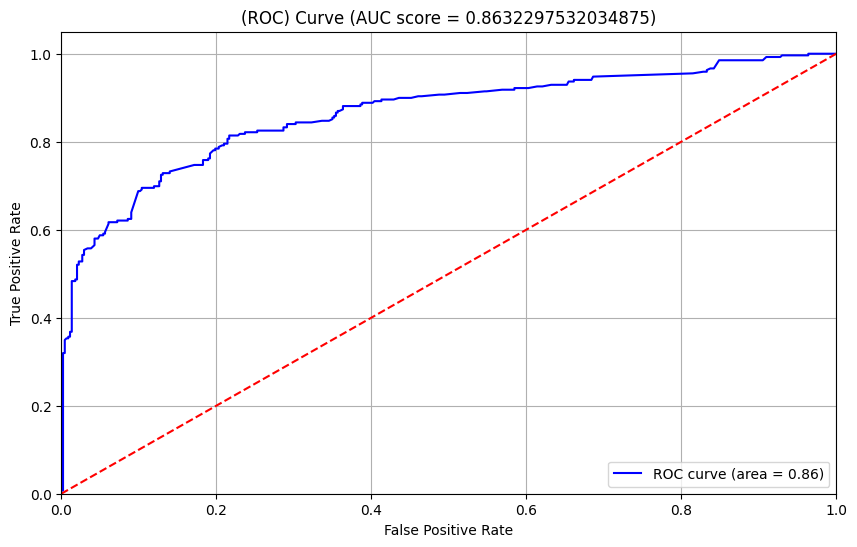

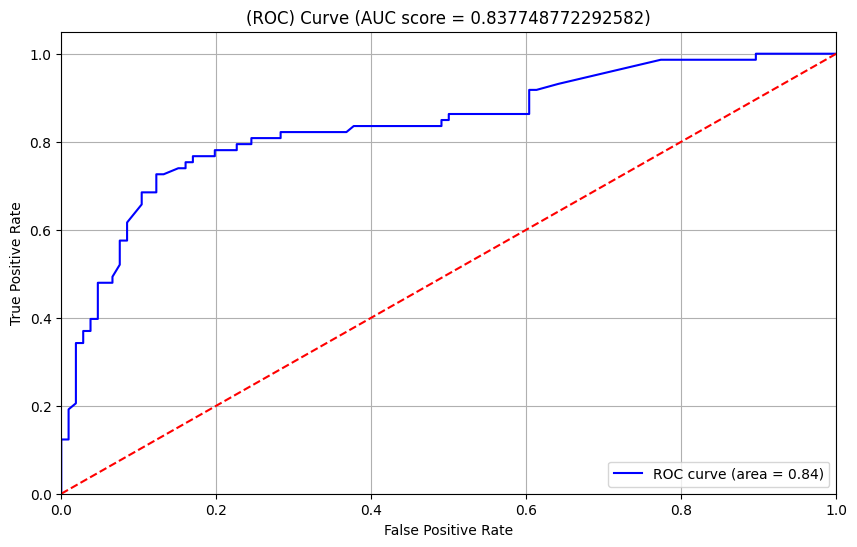

In [ ]:
dv, model = train(df_train, y_train, features, **lr_params)
y_pred = predict(df_val, dv, features, model)
y_pred_train = predict(df_train, dv, features, model)

plot_roc_curve(y_true=y_train, y_score=y_pred_train)
plot_roc_curve(y_true=y_val, y_score=y_pred)

# Use Standard Scaler

In [ ]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

def train(df_train, y_train, features, **lr_params):
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    X_train = scaler.fit_transform(X_train)

    model = LogisticRegression(**lr_params)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, features, model):
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    X = scaler.fit_transform(X)
    
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


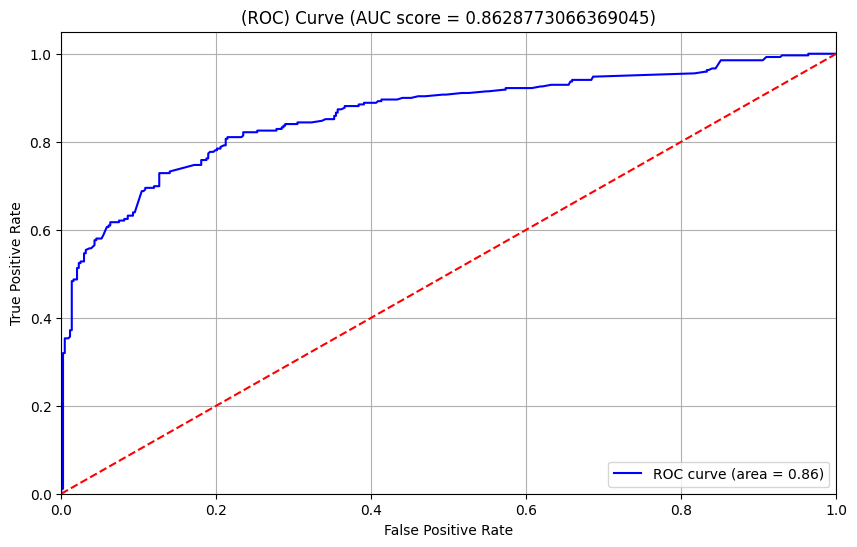

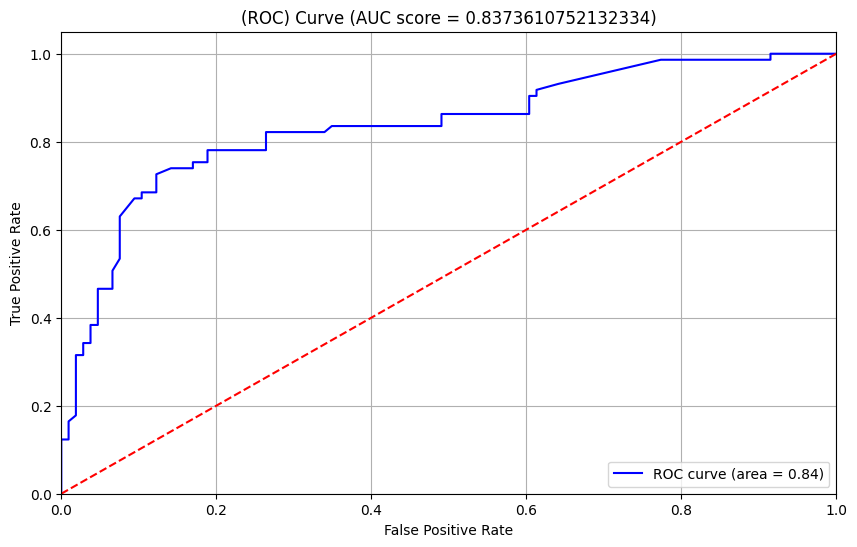

In [ ]:
dv, model = train(df_train, y_train, features, **lr_params)
y_pred = predict(df_val, dv, features, model)
y_pred_train = predict(df_train, dv, features, model)

plot_roc_curve(y_true=y_train, y_score=y_pred_train)
plot_roc_curve(y_true=y_val, y_score=y_pred)

In [ ]:
features = ['age', 'sex', 'pclass', 'sibsp', 'solo', 'parch']
for C in [0.001, 0.01, 0.1, 1, 10, 50, 75, 100, 150, 1000]:
    lr_params['C'] = C
    dv, model = train(df_train, y_train, features, **lr_params)
    y_pred = predict(df_val, dv, features, model)
    y_pred_train = predict(df_train, dv, features, model)
    score = roc_auc_score(y_val, y_pred)
    print((C, score))    

(0.001, 0.8068622383044715)
(0.01, 0.81216076505557)
(0.1, 0.819139312483846)
(1, 0.8315456190230033)
(10, 0.8394287929697596)
(50, 0.8373610752132334)
(75, 0.8371026104936676)
(100, 0.8371026104936676)
(150, 0.8369733781338847)
(1000, 0.836585681054536)


In [ ]:
features = ['age', 'sex', 'pclass', 'sibsp', 'solo', 'parch']
for C in range(1, 21, 1):
    lr_params['C'] = C
    dv, model = train(df_train, y_train, features, **lr_params)
    y_pred = predict(df_val, dv, features, model)
    y_pred_train = predict(df_train, dv, features, model)
    score = roc_auc_score(y_val, y_pred)
    print((C, score))    


(1, 0.8315456190230033)
(2, 0.8347764280175756)
(3, 0.8373610752132333)
(4, 0.8381364693719305)
(5, 0.838911863530628)
(6, 0.8383949340914965)
(7, 0.8386533988110622)
(8, 0.8387826311708452)
(9, 0.8390410958904109)
(10, 0.8394287929697596)
(11, 0.8392995606099767)
(12, 0.8391703282501937)
(13, 0.8383949340914965)
(14, 0.8386533988110623)
(15, 0.8382657017317137)
(16, 0.8382657017317137)
(17, 0.8383949340914966)
(18, 0.8386533988110623)
(19, 0.8383949340914966)
(20, 0.8381364693719308)


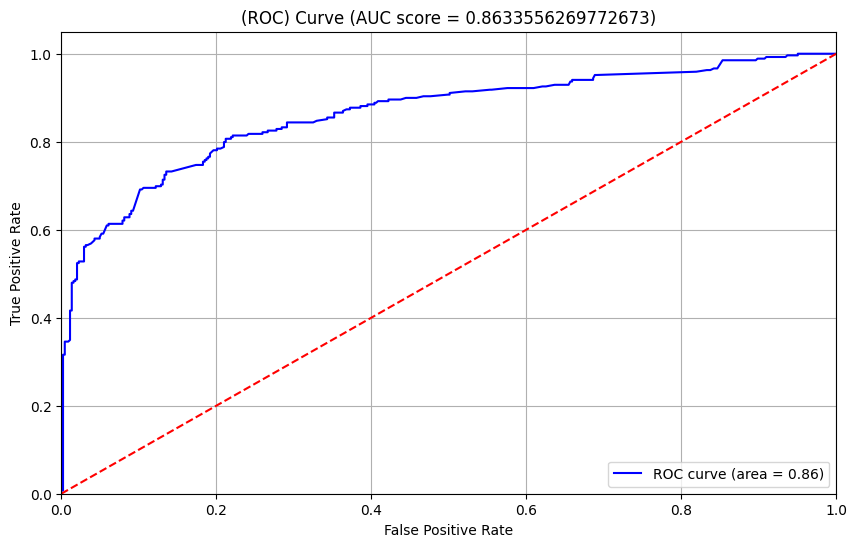

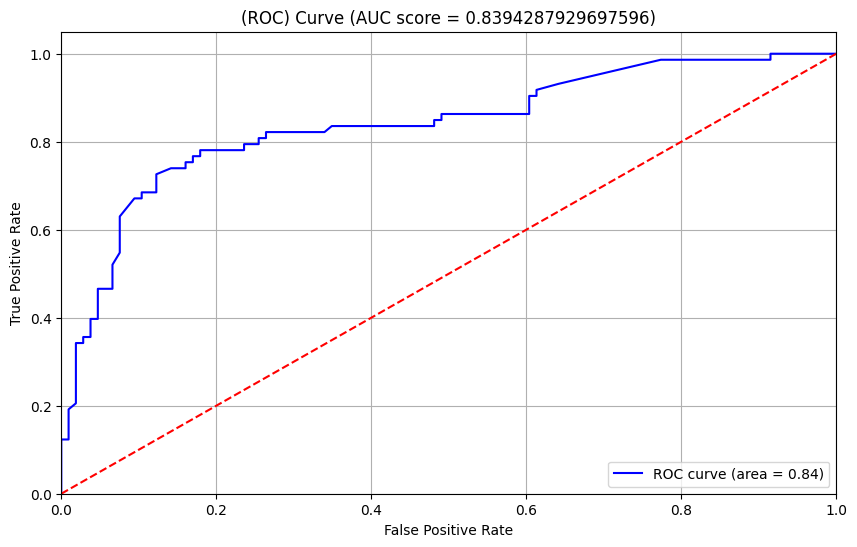

In [ ]:
lr_params['C'] = 10
dv, model = train(df_train, y_train, features, **lr_params)
y_pred = predict(df_val, dv, features, model)
y_pred_train = predict(df_train, dv, features, model)

plot_roc_curve(y_true=y_train, y_score=y_pred_train)
plot_roc_curve(y_true=y_val, y_score=y_pred)